# Paris tree analysis

Last updated : September 13th, 2022

## Introduction

During this project, I will analyze the open source Paris tree dataset downloadable here https://opendata.paris.fr/explore/dataset/les-arbres/. The main goal of this project is to use this analysis to **optimize the city tree maintenance**. 

## 1. Data Loading and Cleaning

First we will load the necessary packages and dataset and then we will carry on with the Cleaning and Analysis.

Before loading the dataset, we have to reencode it using utf-8 to prevent errors and to allow recognition of French characters. I reencode it manually using Sublime Text.

### 1.1 Loading our packages

In [23]:
#Importing packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
#Setting large figure size for Seaborn
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20,"axes.labelsize":18})

### 1.2 Loading the dataset

In [24]:
#Loading the dataset with utf-8 encoding to detect French characters
tree = pd.read_csv("Data/tree_data.csv",encoding="utf-8", sep=";")

### 1.3 Data cleaning

We will start by looking for a primary key in our dataset and assigning it to the id column.

#### 1.3.1 Preliminary analysis

In [25]:
print(len(tree["id"].unique()))
print(len(tree))
#We have the same number of unique ids as the number of rows in our dataset, we can set the index to our id field

#Setting the index to our id fields 
tree.set_index("id", inplace=True)

#Looking at our location_type column
print(tree.location_type.unique())
#Only one type of location ("Tree"), so we can remove this column from our dataset
tree.drop(columns={"location_type"}, inplace=True)

#Looking for incomplete records
tree.info()
#The info function reveals that we have some missing fields in our dataset
#The street_number field is empty so we remove it from our database
tree.drop(columns={"street_number"},inplace=True)

tree.head()

200137
200137
['Tree']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200137 entries, 99874 to 2024745
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   domain              200136 non-null  object 
 1   arrondissement      200137 non-null  object 
 2   additional_address  30902 non-null   object 
 3   street_number       0 non-null       float64
 4   street_location     200137 non-null  object 
 5   id_location         200137 non-null  object 
 6   tree_name           198640 non-null  object 
 7   tree_type           200121 non-null  object 
 8   tree_specie         198385 non-null  object 
 9   variety             36777 non-null   object 
 10  circumference_cm    200137 non-null  int64  
 11  height_m            200137 non-null  int64  
 12  development_stage   132932 non-null  object 
 13  outstanding         137039 non-null  float64
 14  geo_point_2d_a      200137 non-null  float64
 15  geo_po

,domain,arrondissement,additional_address,street_location,id_location,tree_name,tree_type,tree_specie,variety,circumference_cm,height_m,development_stage,outstanding,geo_point_2d_a,geo_point_2d_b
id,,,,,,,,,,,,,,,
99874,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20,5,NaN,0.0,48.857620,2.320962
99875,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65,8,A,NaN,48.857656,2.321031
99876,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90,10,A,NaN,48.857705,2.321061
99877,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60,8,A,NaN,48.857722,2.321006
99878,Garden,PARIS 17E ARRDT,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38,0,NaN,NaN,48.890435,2.315289


In [26]:
#Looking at the arrondissement column
tree.arrondissement.unique()
#Our dataset encompasses all of the 20 paris districts as well as some departments of Ile-de-France
#There are special columns for the main forests of Paris (bois de Vincennes and bois de Boulogne)

#Looking at the outstanding column
tree.outstanding.unique()
#Boolean value with some missing fields

#Looking at the id_location field
len(tree.id_location.unique())
#There are 68904 unique locations, which means that some trees will be at the same locations

#Looking if there are different coordinates for tree at the same id_locations
subset = tree.groupby("id_location").agg(max_arr = ('arrondissement','max'), min_arr = ('arrondissement','min'),
                               max_loc = ('street_location','max'), min_loc = ('street_location','min'),
                               max_lat = ('geo_point_2d_a','max'), min_lat = ('geo_point_2d_a','min'),
                               max_long = ('geo_point_2d_b','max'), min_long = ('geo_point_2d_b','min'))

#Checking if id_location and street_location field are correlated
subset.loc[subset.max_loc != subset.min_loc]
#They are not correlated, and it is easy to see that the max and min lat, long and arrondissement fields are also not correlated

,max_arr,min_arr,max_loc,min_loc,max_lat,min_lat,max_long,min_long
id_location,,,,,,,,
0.00E+00,PARIS 17E ARRDT,PARIS 14E ARRDT,PARC MONTSOURIS,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,48.891790,48.822204,2.338106,2.299761
000A0001,PARIS 17E ARRDT,PARIS 14E ARRDT,PARC MONTSOURIS,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,48.889081,48.824114,2.338959,2.299095
000A0002,PARIS 17E ARRDT,PARIS 15E ARRDT,PARC GEORGES BRASSENS / 2 PLACE JACQUES MARETTE,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,48.889140,48.833096,2.315472,2.299237
000A0003,PARIS 17E ARRDT,PARIS 14E ARRDT,PARC MONTSOURIS,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,48.889201,48.823903,2.339368,2.299204
000A0004,PARIS 17E ARRDT,PARIS 15E ARRDT,PARC GEORGES BRASSENS / 2 PLACE JACQUES MARETTE,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,48.889261,48.833083,2.315585,2.299095
...,...,...,...,...,...,...,...,...
D00000105001,SEINE-SAINT-DENIS,HAUTS-DE-SEINE,CIMETIERE DE PANTIN / DIV 105,CIMETIERE DE BAGNEUX / DIV 105,48.906510,48.802667,2.414876,2.304779
D00000105002,SEINE-SAINT-DENIS,HAUTS-DE-SEINE,CIMETIERE DE PANTIN / DIV 105,CIMETIERE DE BAGNEUX / DIV 105,48.906598,48.802881,2.414994,2.304987
D00000105003,SEINE-SAINT-DENIS,HAUTS-DE-SEINE,CIMETIERE DE PANTIN / DIV 105,CIMETIERE DE BAGNEUX / DIV 105,48.906744,48.802923,2.415016,2.305001


#### 1.3.2 Detecting and cleaning illogical values

In [27]:
#Using the describe function to look for outliers
tree.describe()

#It seems that some values for circumference and height are far from the norm, but there are no outliers in the coordinates
#Looking at the internet, the maximum circumference of a tree is 31.3m, or 3130 cm.

len(tree.loc[tree.circumference_cm > 3130])
#20 trees have a reported circumference higher than 31.3m

#The largest tree in France has a circumference of 13.9m (source https://www.monumentaltrees.com/fr/recordsdecirconference/fra/)
#which is the value we will keep here

len(tree.loc[tree.circumference_cm > 1390])
#35 trees have a reported circumference of over 1390
#Since these values are false, we will replace them with NAN for now
tree.loc[tree.circumference_cm > 1390, 'circumference_cm'] = np.nan

#We will proceed the same for height
#The highest tree in France has a height of 66m (source https://www.monumentaltrees.com/fr/recordsdhauteur/fra/)

len(tree.loc[tree.height_m > 66])
#353 records have heights over this threshold
#We will also replace these with NAN

tree.loc[tree.height_m > 66, 'height_m'] = np.nan

#Checking for duplicate development_stage values
tree.development_stage.unique()
#No illogical values, A = Adult, J=Young, JA = Young Adult, M = Mature

tree.head()

,domain,arrondissement,additional_address,street_location,id_location,tree_name,tree_type,tree_specie,variety,circumference_cm,height_m,development_stage,outstanding,geo_point_2d_a,geo_point_2d_b
id,,,,,,,,,,,,,,,
99874,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20.0,5.0,NaN,0.0,48.857620,2.320962
99875,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65.0,8.0,A,NaN,48.857656,2.321031
99876,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90.0,10.0,A,NaN,48.857705,2.321061
99877,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60.0,8.0,A,NaN,48.857722,2.321006
99878,Garden,PARIS 17E ARRDT,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38.0,0.0,NaN,NaN,48.890435,2.315289


#### 1.3.3 Cleaning categorical variables using Levenshtein distance

In [28]:
#Looking for close duplicates in the name and species fields
tree_names = tree.tree_name.dropna().unique()

#Creating a function that will analyze duplicate names and return a sorted list of the most similar

#Importing the itertools combinations function that will generate unique pairs of our list
from itertools import combinations

#Importing Levenshtein, an algorithm that calculates the distance between the strings
from Levenshtein import distance as levenshtein_distance

#Defining our distance function
def calculate_lev_dist(x):
    return levenshtein_distance(x['first'],x['second'])


def check_similarities(df: pd.DataFrame, column: str):
    #Creating a list of unique names
    name_list = df[column].dropna().unique()
    #Creating an empty array
    names = []
    #Iterating over all pairs of our list
    for c in combinations(name_list,2):
        #Appending a dictionary to the list with the 2 elements
        names.append({'first': c[0], 'second': c[1]})

    #Creating a dataframe from the dictionary
    names = pd.DataFrame(names)
    
    #Calculating the Levenshtein distance between categories and storing it into the lev_dist column
    names['lev_dist'] = names.apply(calculate_lev_dist, axis=1)
    
    names.sort_values(by="lev_dist", inplace=True)
    return names

In [29]:
check_similarities(tree, "tree_name").head(20)

#We look at the pairs with low Levenshtein distance similarity, and we find 2 pairs with the same name except for an accent:
#Aubépine / Aubepine and Troene / Troëne

#Let's find out wich of these pair is the most frequent and replace occurences of the least frequent name with its new name
print (len(tree.loc[tree.tree_name == "Aubépine"]) > len(tree.loc[tree.tree_name == "Aubepine"]))
#Returns true
#Replacing the least frequent name
tree.loc[tree.tree_name == "Aubepine", "tree_name"] = "Aubépine"

print (len(tree.loc[tree.tree_name == "Troene"]) > len(tree.loc[tree.tree_name == "Troëne"]))
#Returns true

#Replacing the least frequent name
tree.loc[tree.tree_name == "Troëne", "tree_name"] = "Troene"

tree.head()

True
True


,domain,arrondissement,additional_address,street_location,id_location,tree_name,tree_type,tree_specie,variety,circumference_cm,height_m,development_stage,outstanding,geo_point_2d_a,geo_point_2d_b
id,,,,,,,,,,,,,,,
99874,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,19,Marronnier,Aesculus,hippocastanum,NaN,20.0,5.0,NaN,0.0,48.857620,2.320962
99875,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,20,If,Taxus,baccata,NaN,65.0,8.0,A,NaN,48.857656,2.321031
99876,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,21,If,Taxus,baccata,NaN,90.0,10.0,A,NaN,48.857705,2.321061
99877,Garden,PARIS 7E ARRDT,NaN,MAIRIE DU 7E 116 RUE DE GRENELLE PARIS 7E,22,Erable,Acer,negundo,NaN,60.0,8.0,A,NaN,48.857722,2.321006
99878,Garden,PARIS 17E ARRDT,NaN,PARC CLICHY-BATIGNOLLES-MARTIN LUTHER KING,000G0037,Arbre à miel,Tetradium,daniellii,NaN,38.0,0.0,NaN,NaN,48.890435,2.315289


In [30]:
# We will now do the same with tree_type, tree_specie and variety
check_similarities(tree, "tree_type").head(20)
#No duplicates, Chimonanthus and Chionanthus are 2 different species

,first,second,lev_dist
13844,Chimonanthus,Chionanthus,1
4218,Ulmus,Alnus,2
1256,Fagus,Ficus,2
225,Taxus,Buxus,2
13570,Carya,Garrya,2
6321,Corylus,Cornus,2
2828,Pinus,Pyrus,2
500,Acer,Acca,2
3914,Pyrus,Morus,2
2850,Pinus,Alnus,2


In [31]:
#We will now look at species
check_similarities(tree, "tree_specie").head(30)
#Looking at the list, we have some errors :
#Europea is not a tree species
tree.loc[tree.tree_specie=="europea","tree_specie"] = "europaea"

#Same is true for xerubescens (the real name is x erubescens)
tree.loc[tree.tree_specie=="xerubescens","tree_specie"] = "x erubescens"

#No other mistakes can be detected

In [32]:
#Let's investigate the variety
#check_similarities(tree, "variety").head(30)

#We will remove the extra quote signs from the variety and rerun our function
tree["variety"] = tree["variety"].apply(lambda x: str(x).replace("'",""))

check_similarities(tree, "variety").head(30)

#Falicifolia is not a variety and we will replace it with its closest match Salicifolia
tree.loc[tree.variety=="Falicifolia","variety"] = "Salicifolia"

#We see that some nan values are coded as strings
tree.loc[tree.variety=="nan","variety"] = np.nan

#Just in case, we apply the same function to other strin columns
tree.loc[tree.tree_name=="nan","tree_name"] = np.nan
tree.loc[tree.tree_specie=="nan","tree_specie"] = np.nan
tree.loc[tree.tree_type=="nan","tree_type"] = np.nan

#Renaming the coordinates to latitude and longitude
tree.rename(columns={"geo_point_2d_a": "latitude", "geo_point_2d_b": "longitude"}, inplace=True)


#### 1.3.4 Dealing with NA and null values

In [33]:
#Looking at height_m and circumference_cm values
sorted(tree.height_m.unique())
sorted(tree.circumference_cm.unique())
#Those variables are not continuous, they are rounded to the nearest integer.
#There is also a "nan" string value that we will have to remove

#This code will convert all non numeric values to nan
tree["height_m"] = pd.to_numeric(tree["height_m"], errors='coerce')
tree["circumference_cm"] = pd.to_numeric(tree["circumference_cm"], errors='coerce')

#Handling nan and null values.
#Since height_m is rounded to the nearest meter, values = 0 represent all trees with a height <0.5m
#For circumference_cm it represents all trees with circumference < 0.5cm 
len(tree[tree["circumference_cm"] == 0])
#This represents ~26k columns on our ~200k records, which is an important part of the dataset 

25867

The number of records of trees with null circumference and height is important, so we can't assume those aren't errors in the database, but probably saplings that are very small.

We will now use **data imputation** to replace NaN values in our numeric variables.

First we will look at the distribution of both variables to see what kind of imputation technique we can use.

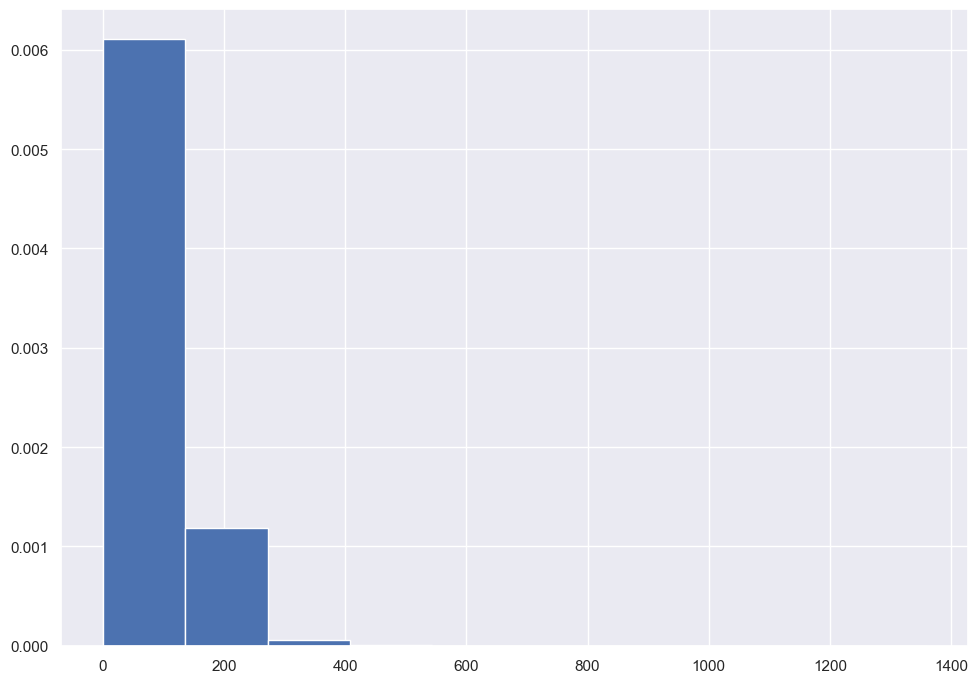

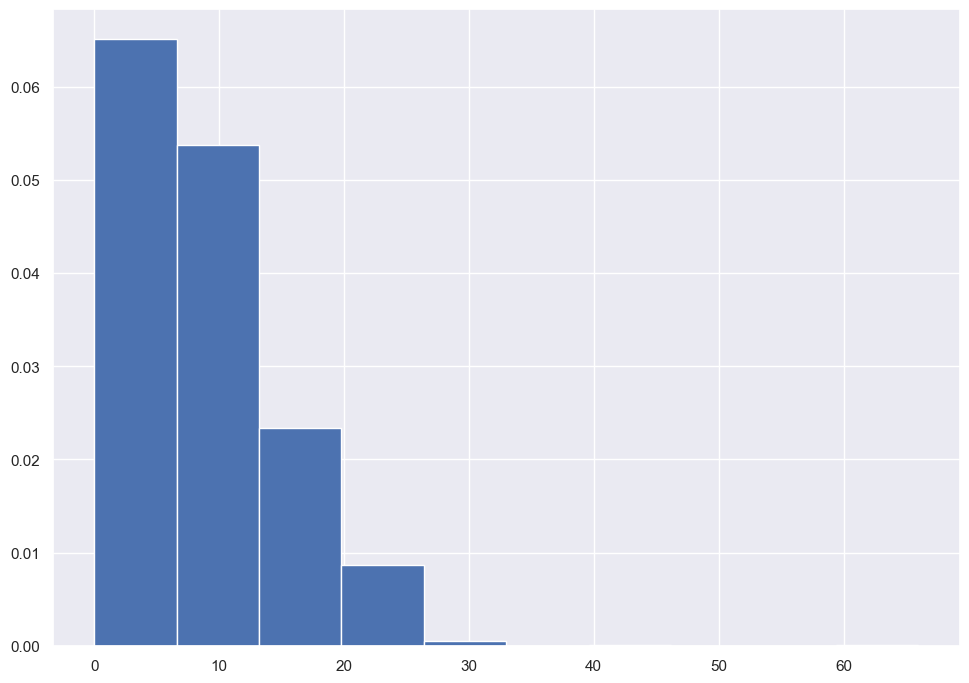

In [34]:
#Looking at variables distribution
tree.circumference_cm.hist(density = True)
plt.show()
tree.height_m.hist(density=True)
plt.show()

Even without looking at statistical indicators, we can clearly see that **both variables are not normally distributed** 

Therefore, we will use **median imputation** to replace nan values. 

In [35]:
#Since it is not possible to have a null height or circumference, we will replace null values by np.nan
tree.loc[tree.circumference_cm.isna(), "circumference_cm"] = tree.circumference_cm.median()
tree.loc[tree.height_m.isna(), "height_m"] = tree.height_m.median()

#Adding a circumference_m column for easier comparison between height and circumference
tree["circumference_m"] = tree["circumference_cm"] / 100

That's the end of the data cleaning process. We will now start to analyze our dataset.

## 2. Data Analysis

Let's start by doing univariate analysis of numeric and categorical variables.

### 2.1 Analysis of numeric variables

#### 2.1.1 Distribution Analysis

In [36]:
tree.describe()

,circumference_cm,height_m,outstanding,latitude,longitude,circumference_m
count,200137.000000,200137.000000,137039.000000,200137.000000,200137.000000,200137.000000
mean,79.860341,8.356741,0.001343,48.854491,2.348208,0.798603
std,64.862641,6.299368,0.036618,0.030234,0.051220,0.648626
min,0.000000,0.000000,0.000000,48.742290,2.210241,0.000000
25%,30.000000,5.000000,0.000000,48.835021,2.307530,0.300000
50%,70.000000,8.000000,0.000000,48.854162,2.351095,0.700000
75%,115.000000,12.000000,0.000000,48.876447,2.386838,1.150000
max,1360.000000,66.000000,1.000000,48.911485,2.469759,13.600000


Circumference Mean: 0.8
Circumference Median: 0.7
Circumference Mode: 0.0
Circumference Variance: 0.42
Circumference Standard deviation: 0.65
Circumference Skewness: 1.98
Circumference Kurtosis: 18.11


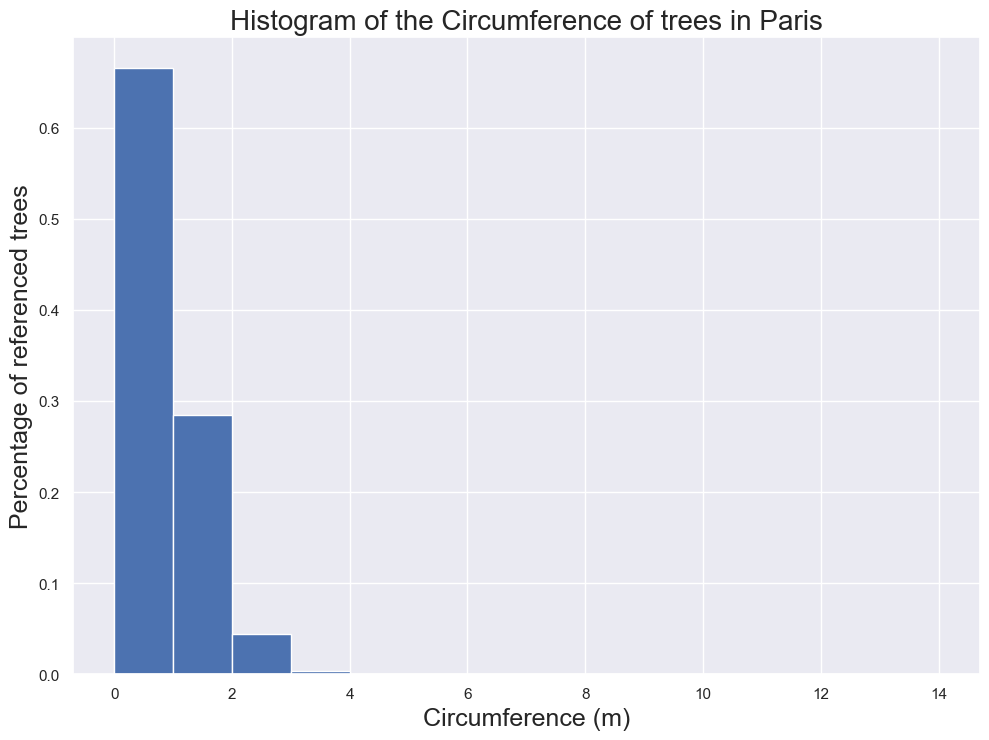

Height Mean: 8.36
Height Median: 8.0
Height Mode: 0.0
Height Variance: 39.68
Height Standard deviation: 6.3
Height Skewness: 0.75
Height Kurtosis: 2.15


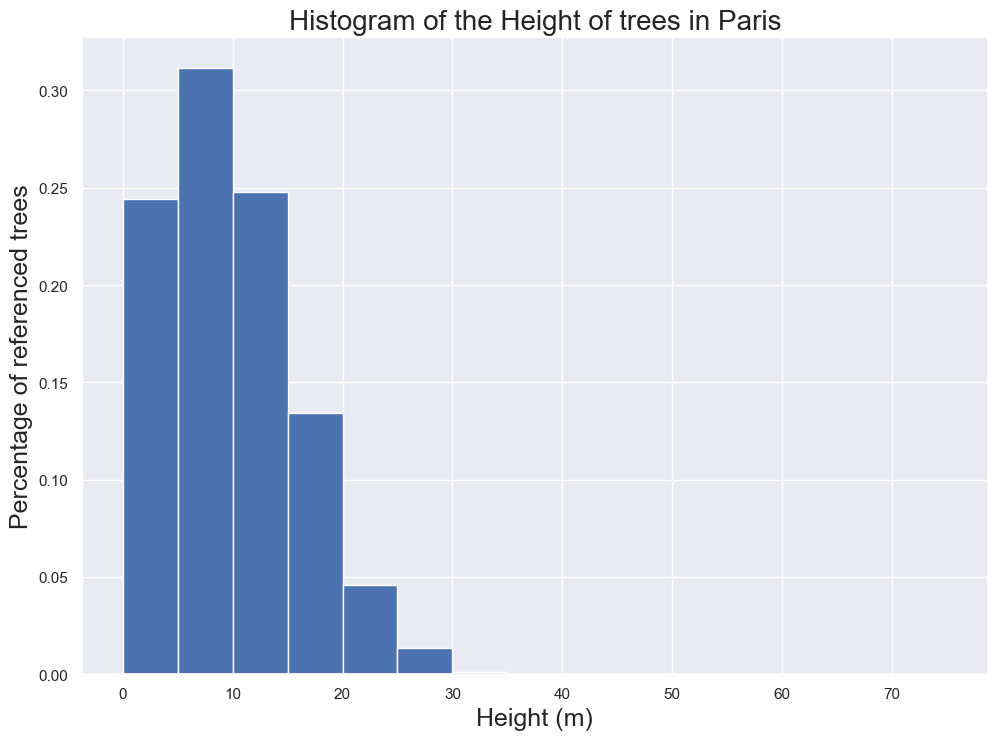

Latitude Mean: 48.85
Latitude Median: 48.85416209
Latitude Mode: 48.84715692
Latitude Variance: 0.0
Latitude Standard deviation: 0.03
Latitude Skewness: -0.51
Latitude Kurtosis: 0.85


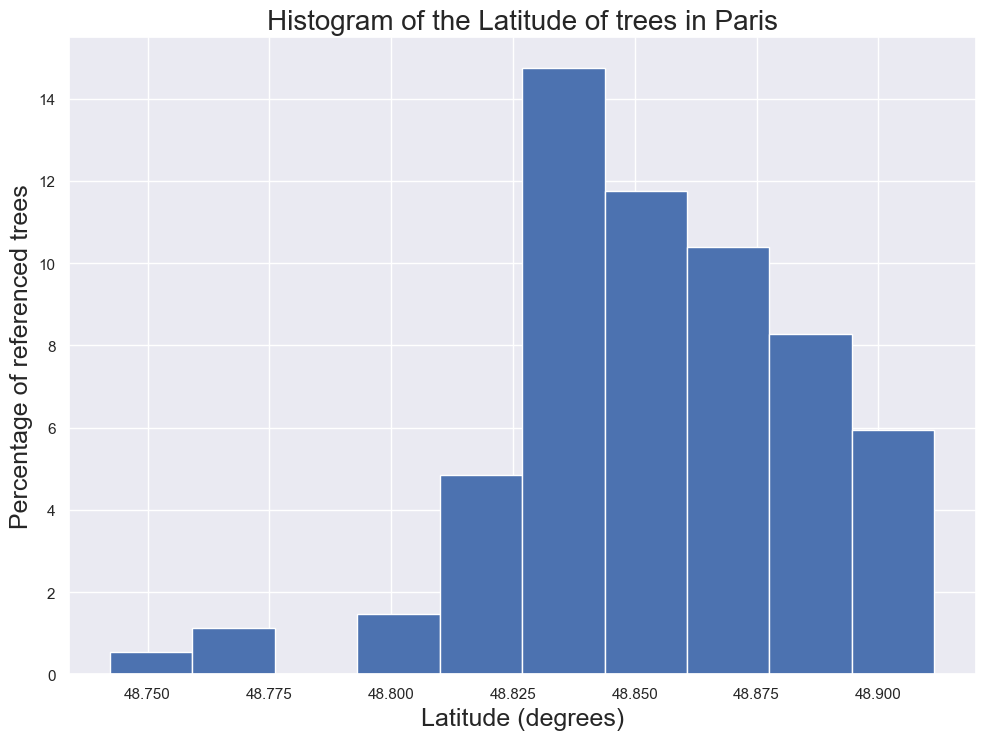

Longitude Mean: 2.35
Longitude Median: 2.351095166
Longitude Mode: 2.25864685
Longitude Variance: 0.0
Longitude Standard deviation: 0.05
Longitude Skewness: -0.01
Longitude Kurtosis: -0.73


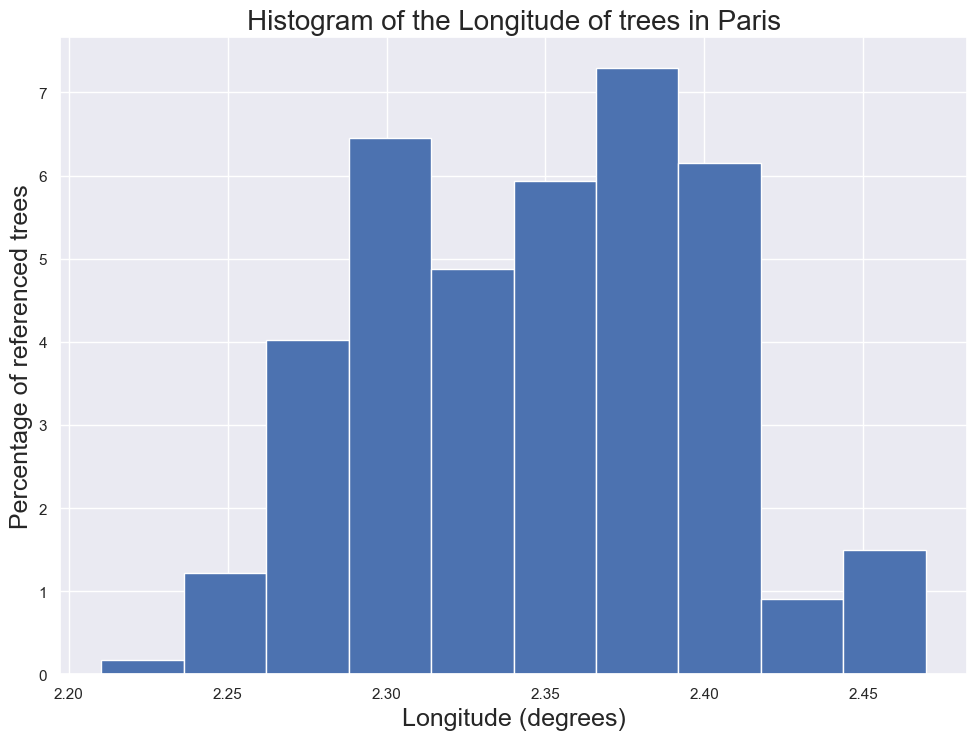

In [37]:
#Creating a list of lists of the numerical columns we will study along with their name and unit
columns = [["Circumference","circumference_m", "m",np.arange(0,15,1)],["Height","height_m", "m",np.arange(0,80,5)],
           ["Latitude","latitude", "degrees"], ["Longitude","longitude", "degrees"]]

for c in columns:
    #Calculating basic statistics for our data
    print(c[0], "Mean:", round(tree[c[1]].mean(),2))
    print(c[0], "Median:", tree[c[1]].median())
    print(c[0], "Mode:", tree[[c[1]]].mode().values[0][0])
    print(c[0], "Variance:",round(tree[c[1]].var(ddof=0),2))
    print(c[0], "Standard deviation:",round(tree[c[1]].std(ddof=0),2))
    print(c[0], "Skewness:",round(tree[c[1]].skew(),2))
    print(c[0], "Kurtosis:",round(tree[c[1]].kurtosis(),2))
    #Plotting a histogram of their distribution
    subset = tree[c[1]].dropna()
    if len(c) == 4:
        subset.hist(density=False,bins=c[3],weights=np.ones(len(subset))/len(subset))
    else:
        subset.hist(density=True,bins=10)
    plt.title("Histogram of the "+c[0]+" of trees in Paris")
    plt.xlabel(c[0]+" ("+c[2]+")")
    plt.ylabel("Percentage of referenced trees")
    plt.show()


In [56]:
#Percentage of trees with a circumference over 400cm:
subset = tree[["circumference_cm"]].copy().dropna()
print(subset.loc[subset.circumference_cm>400].count()*100/len(subset))

#Max circumference
tree.circumference_cm.max()

#Percentage of trees with a height over 30m:
subset = tree[["height_m"]].copy().dropna()
print(subset.loc[subset.height_m>30].count()*100/len(subset))

#Max height
subset.max()

circumference_cm    0.104428
dtype: float64
height_m    0.109925
dtype: float64


height_m    66.0
dtype: float64

In [39]:
tree[["circumference_m"]].mode().values[0][0]

0.0

#### 2.1.2 Outlier detection

We will define outliers as values **below the 10th and above the 90th quantile.**

Circumference : Values below 0.0 and above 1.65 are outliers


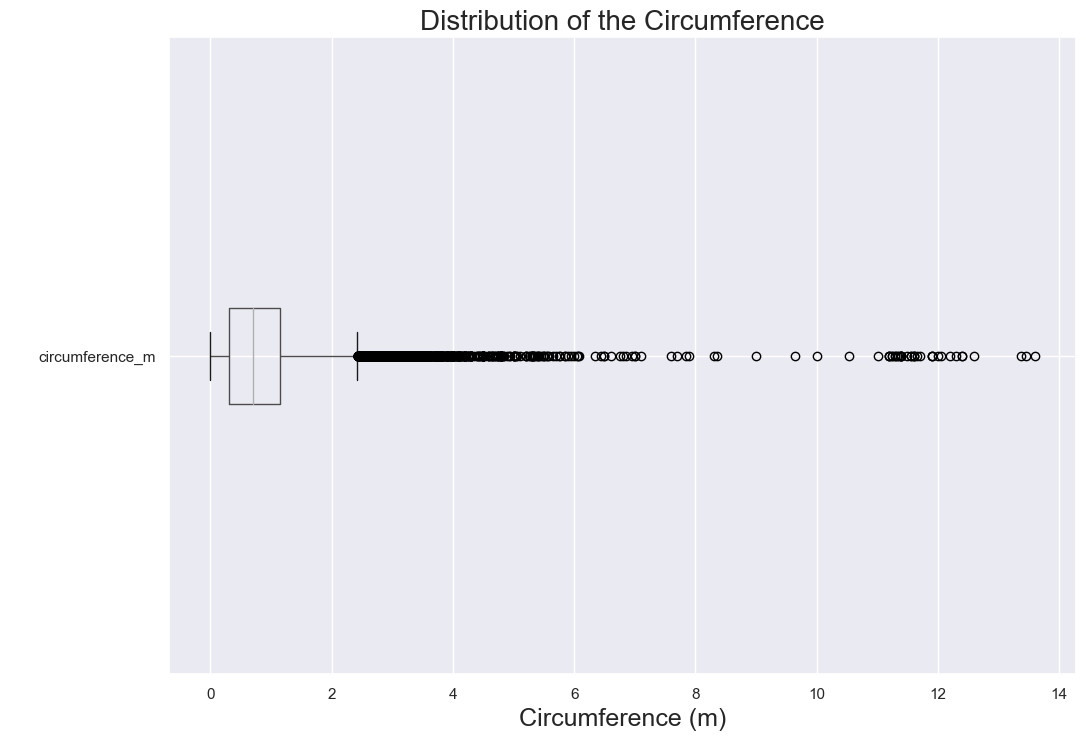

Height : Values below 0.0 and above 16.0 are outliers


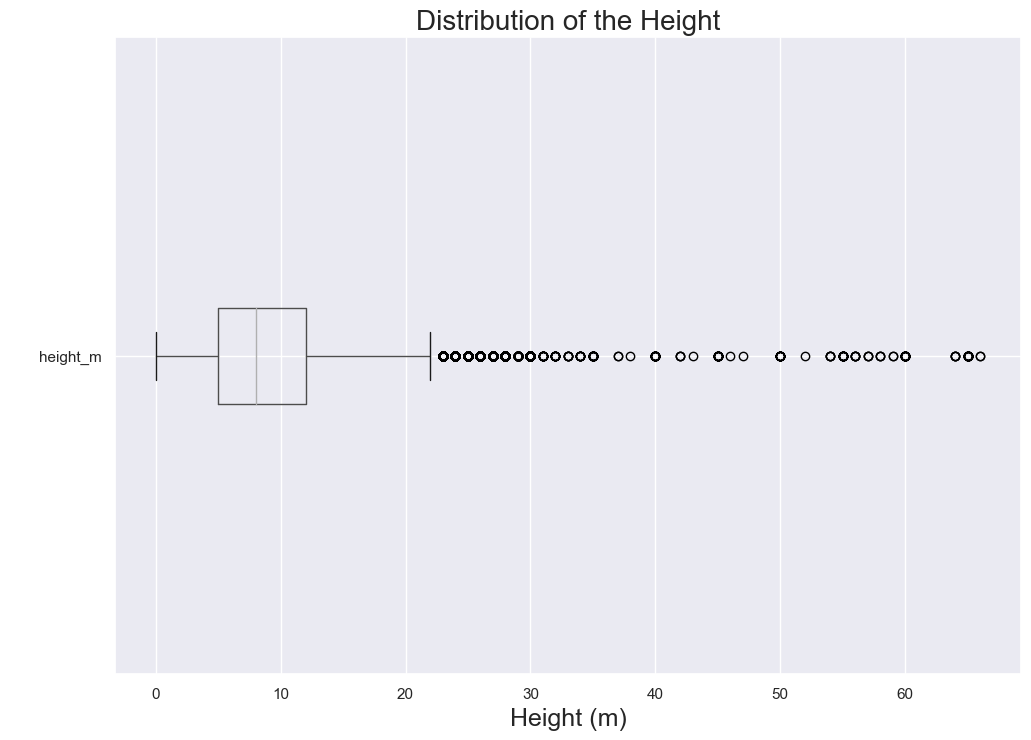

Latitude : Values below 48.822130998 and above 48.894689984 are outliers


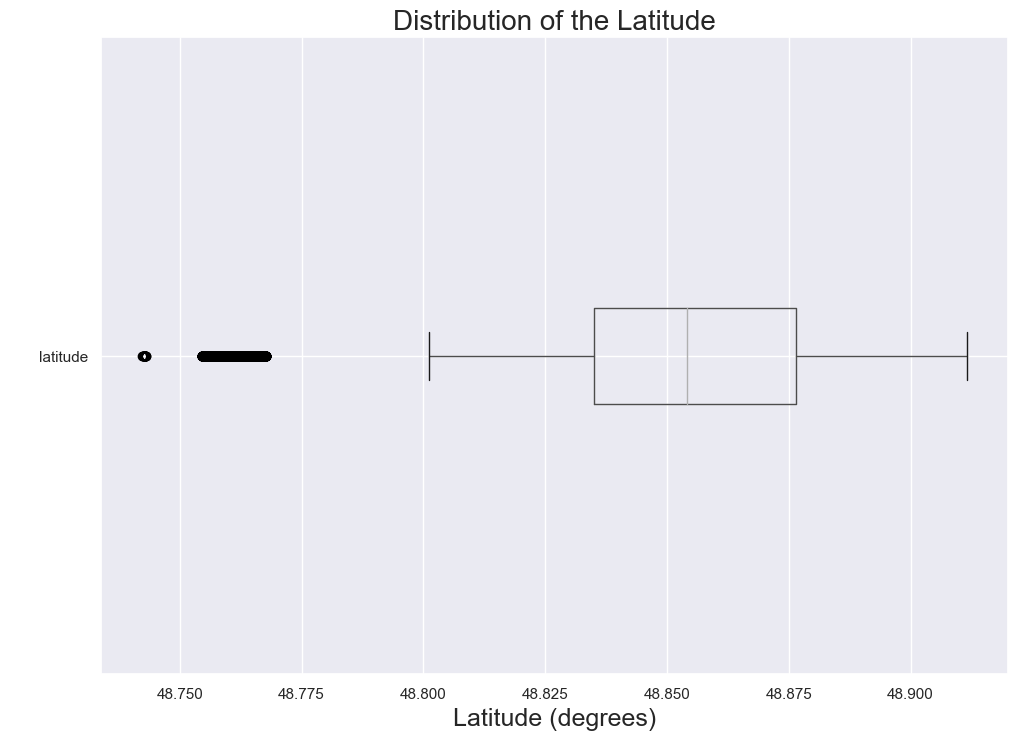

Longitude : Values below 2.2777173788000002 and above 2.411053443 are outliers


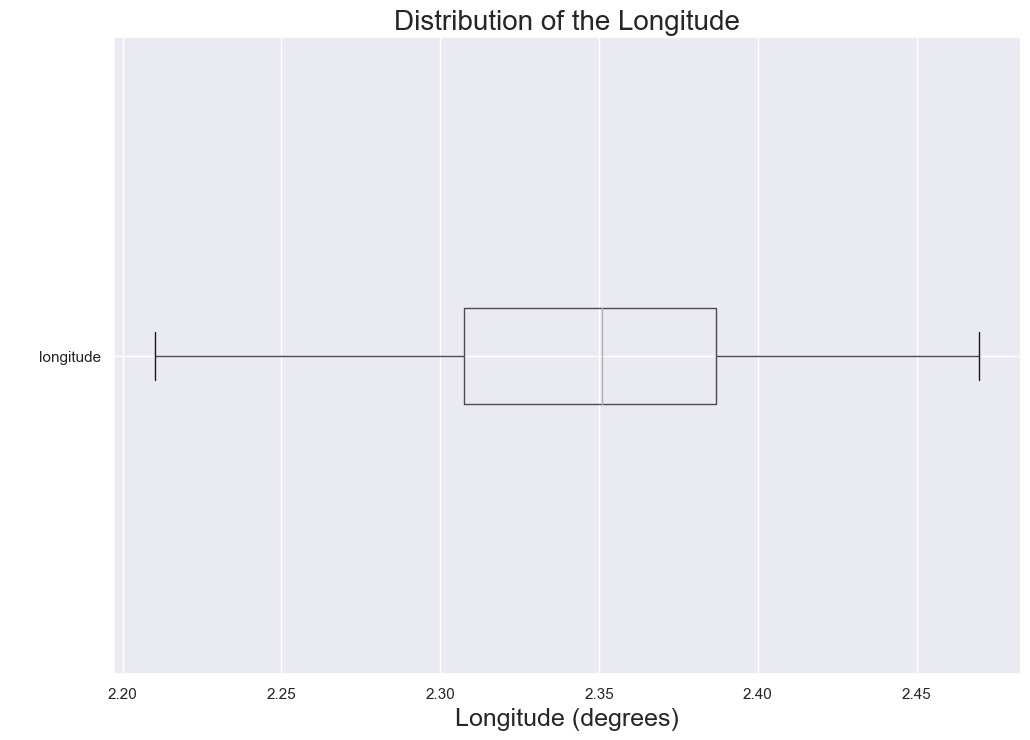

In [40]:
for c in columns:
    q10 = tree[c[1]].quantile(0.1)
    q90 = tree[c[1]].quantile(0.9)
    print(c[0],": Values below",q10,"and above",q90,"are outliers")
    tree.boxplot(column=c[1], vert=False)
    plt.title("Distribution of the "+c[0])
    plt.xlabel(c[0]+" ("+c[2]+")")
    plt.ylabel(" ")
    plt.show()

#### 2.1.3 Concentration of numeric variables (Lorenz curve)

In this part, we will study the concentration of our 2 main numeric variables : circumference and height.

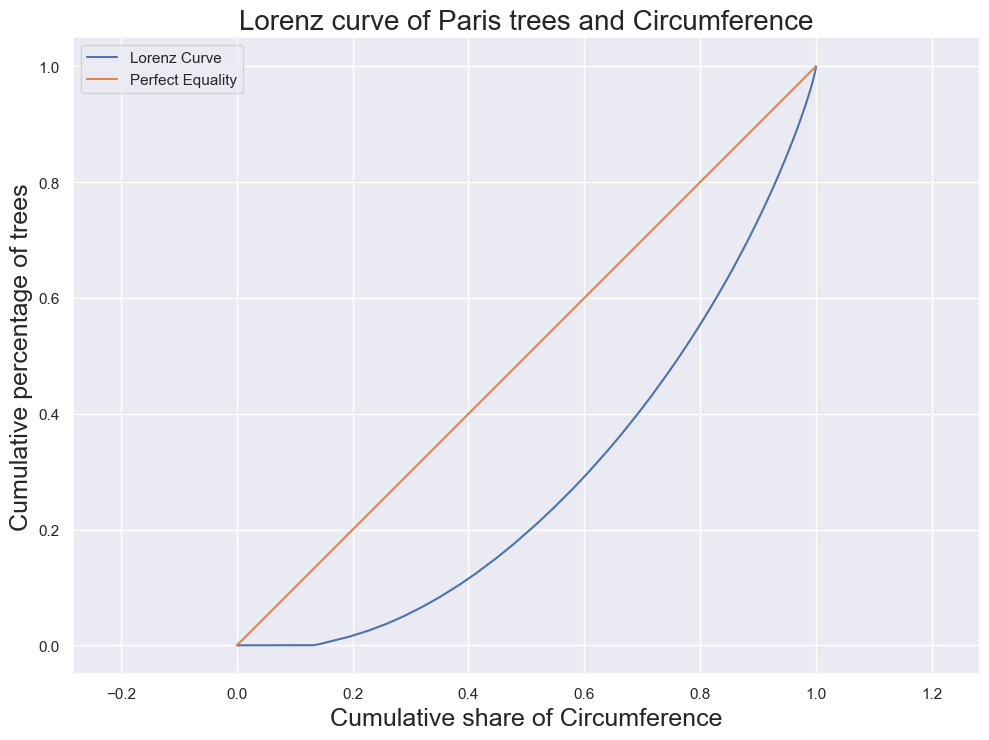

Gini = 0.43222816054914426


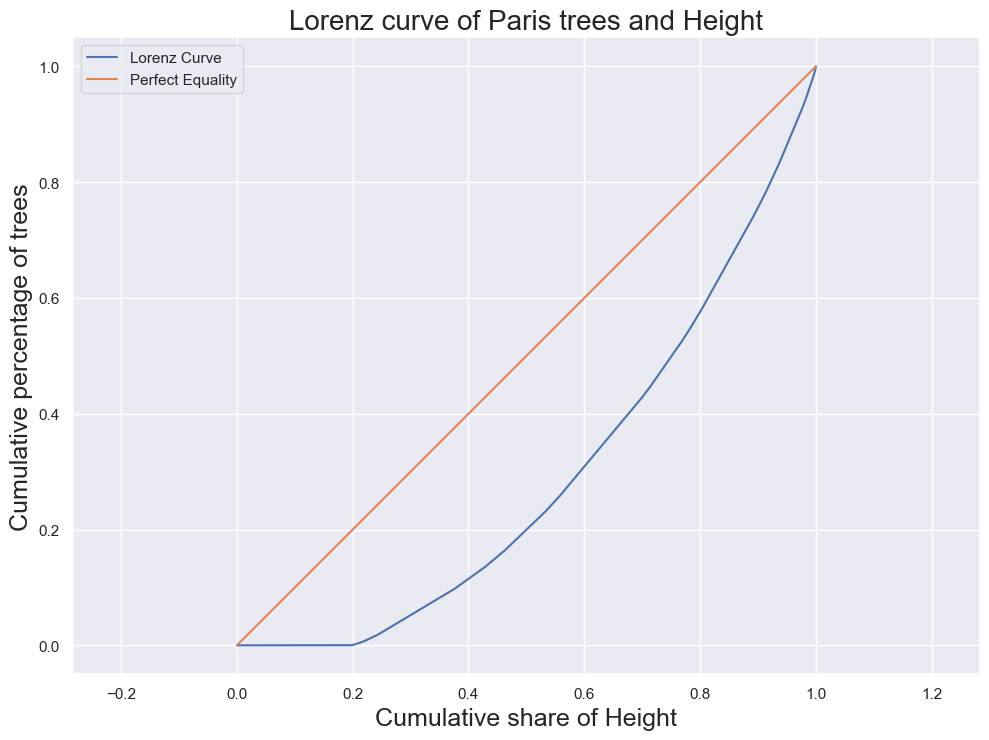

Gini = 0.41748112654622793


In [41]:
num = [["circumference_m","Circumference"],["height_m","Height"]]

for c in num:
    
    subset = tree[c[0]].dropna().values
    n = len(subset)
    lorenz = np.cumsum(np.sort(subset)) / subset.sum()
    lorenz = np.append([0],lorenz) # The Lorenz Curve begins at 0

    plt.axis('equal')
    xaxis = np.linspace(0-1/n,1+1/n,n+1) # There is 1 segment (of size n) for each individual, plus 1 segment at y=0. The first segment starts at 0-1/n and the last one finishes at 1+1/n
    plt.plot(xaxis,lorenz,drawstyle='steps-post', label = 'Lorenz Curve')
    plt.plot(xaxis,xaxis, label = 'Perfect Equality')
    plt.title("Lorenz curve of Paris trees and {}".format(c[1]))
    plt.xlabel("Cumulative share of {}".format(c[1]))
    plt.ylabel("Cumulative percentage of trees")
    plt.legend()
    plt.show()

    AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n # area under the Lorenz Curve. The first segment (lorenz[0]) is halfly below O, so we divide it by 2. We do the same for the mast segment lorenz[-1]
    S = 0.5 - AUC # area between 1st bisector and the Lorenz Curve
    gini = 2*S # Calculation of the gini coefficient
    print("Gini =",gini)

**Conclusion:** In both cases, the Gini index is quite low (0.34 and 0.27) which indicates that the circumference and height of Paris trees is adequately distributed.

### 2.2 Analysis of categorical variables

We will only analyze the variables with relatively few categories, like domain, development_stage and outstanding

#### 2.2.1 Repartition 

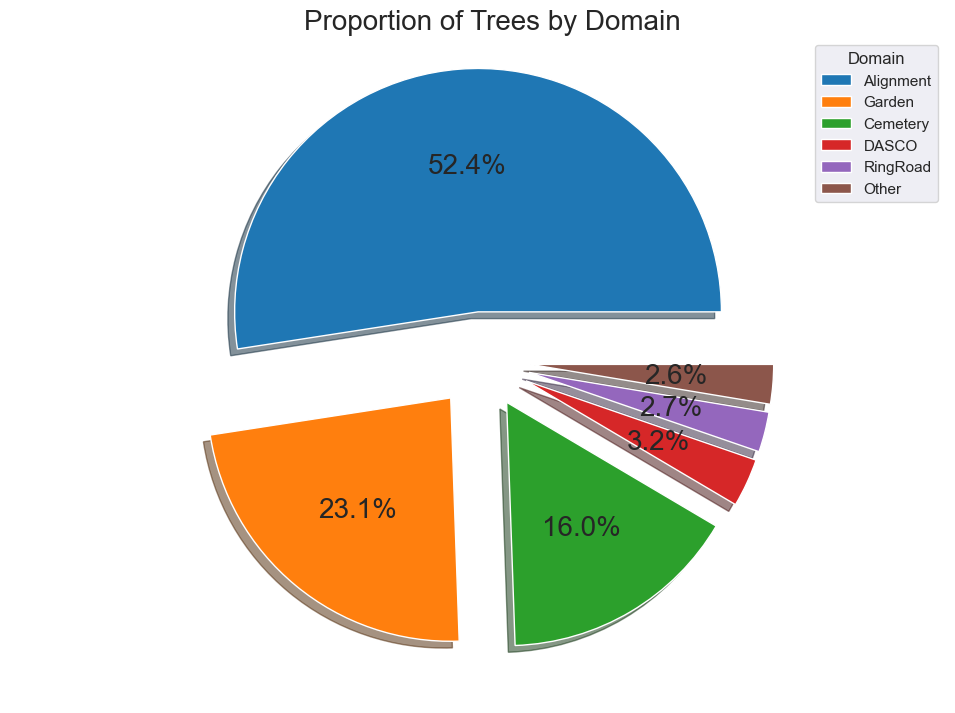

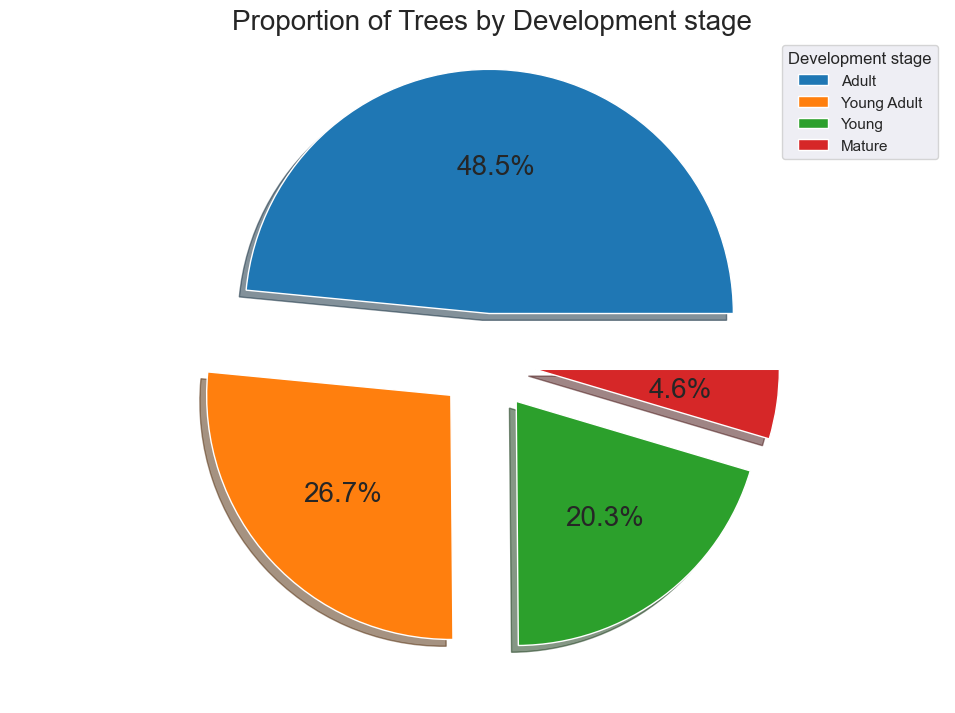

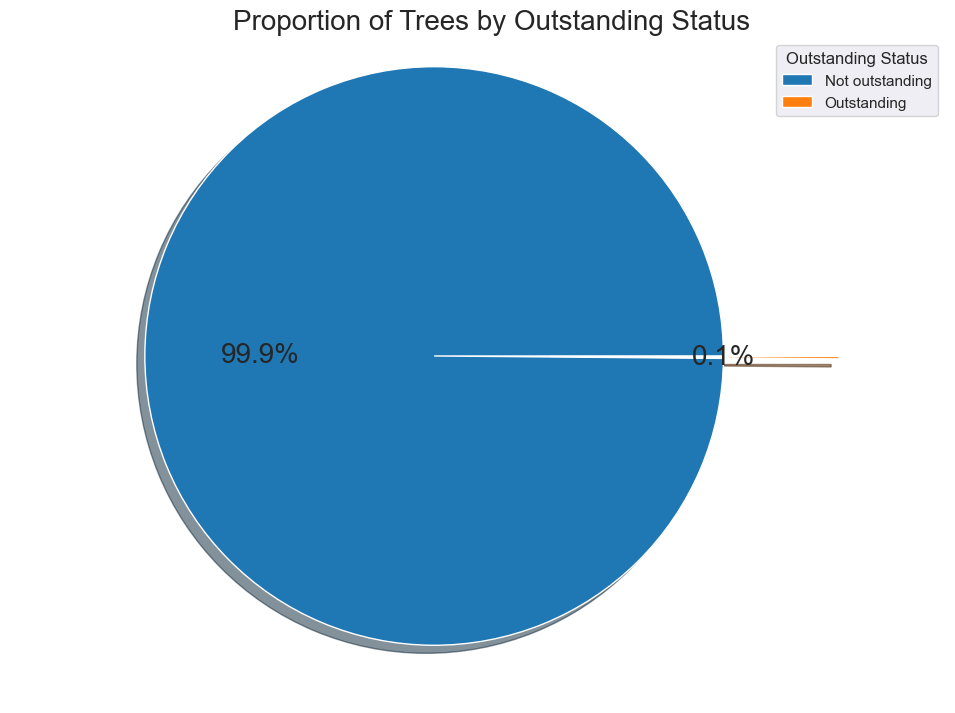

In [42]:
#Creating a list of lists of the categorical columns we will study along with their name and the categories if not explicit
columns = [["domain","Domain"],["development_stage","Development stage","Adult","Young Adult","Young","Mature"],
           ["outstanding","Outstanding Status","Outstanding","Not outstanding"]]
sns.set_palette("tab10")
for c in columns:
    #Creating a Series with the percentage of each values
    subset = tree[c[0]].value_counts(normalize=True)
    #Replacing values < 2% by an "Other" category aggregation
    for s in subset:
        if s < 0.02:
            label = subset[subset==s].index[0]
            subset.drop(labels=[label],inplace=True)
        
    other_count = 1 - subset.sum()
    if other_count != 0:
        subset["Other"] = other_count
    
    #Creating exploding pie array
    expl = [0.2]*len(subset)
    
    subset.plot.pie(autopct='%1.1f%%', shadow=True, labeldistance=None, explode=expl)
    plt.title('Proportion of Trees by '+c[1])
    plt.axis('equal')
    plt.ylabel(" ")
    plt.xlabel(" ")
    if len(c) > 4:
        plt.legend(title=c[1], labels=[c[2],c[3],c[4],c[5]])
    elif len(c) > 2:
        plt.legend(title=c[1], labels=[c[3],c[2]])
    else:
        plt.legend(title=c[1])
    plt.show()
    

#### 2.2.2 Most frequent variables

For variables with too many categories, we will plot the top 5 most frequent category.

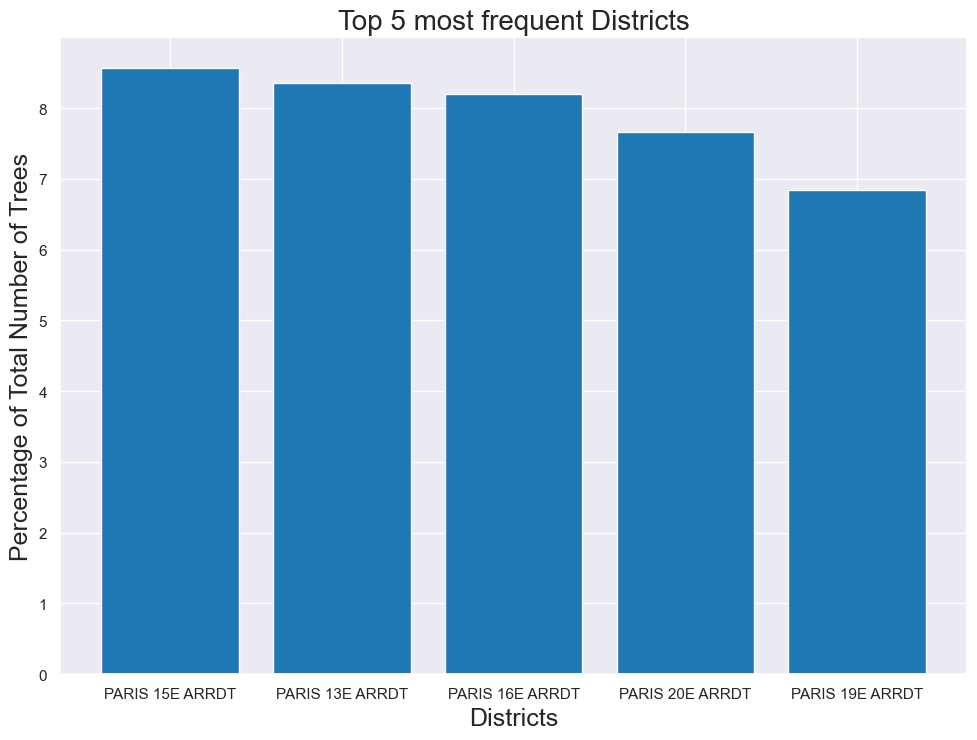

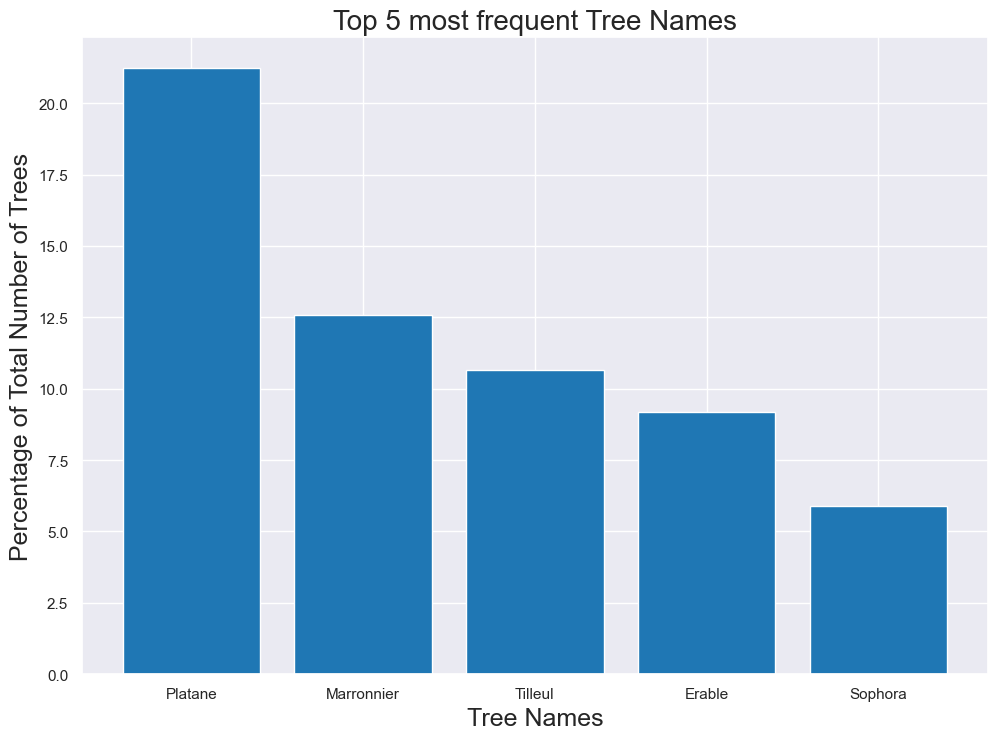

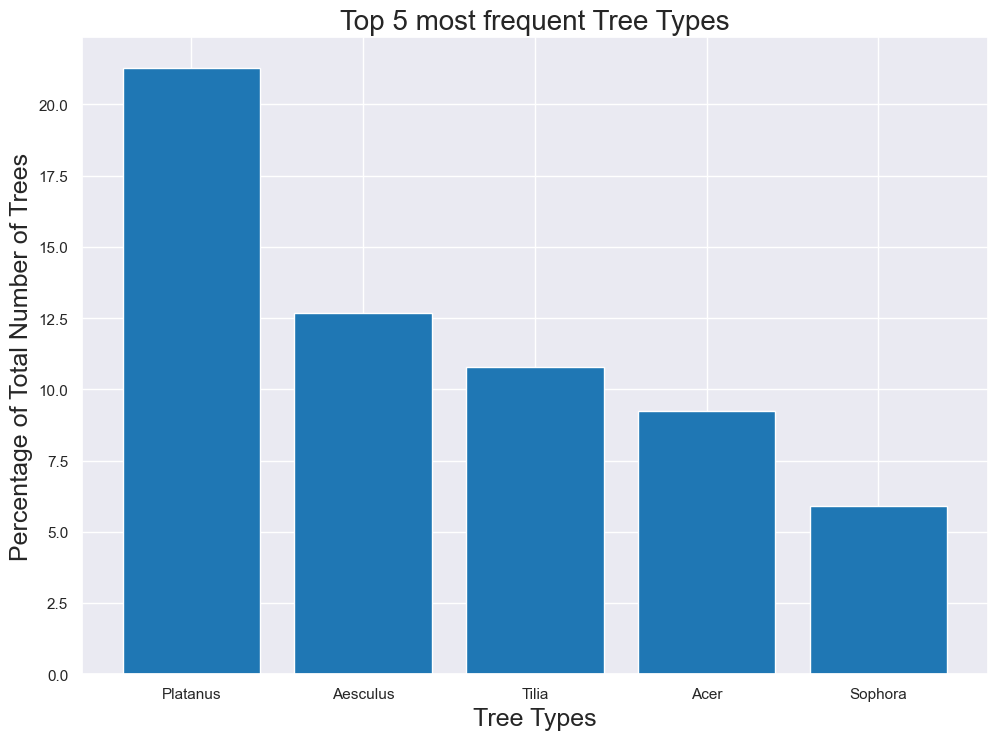

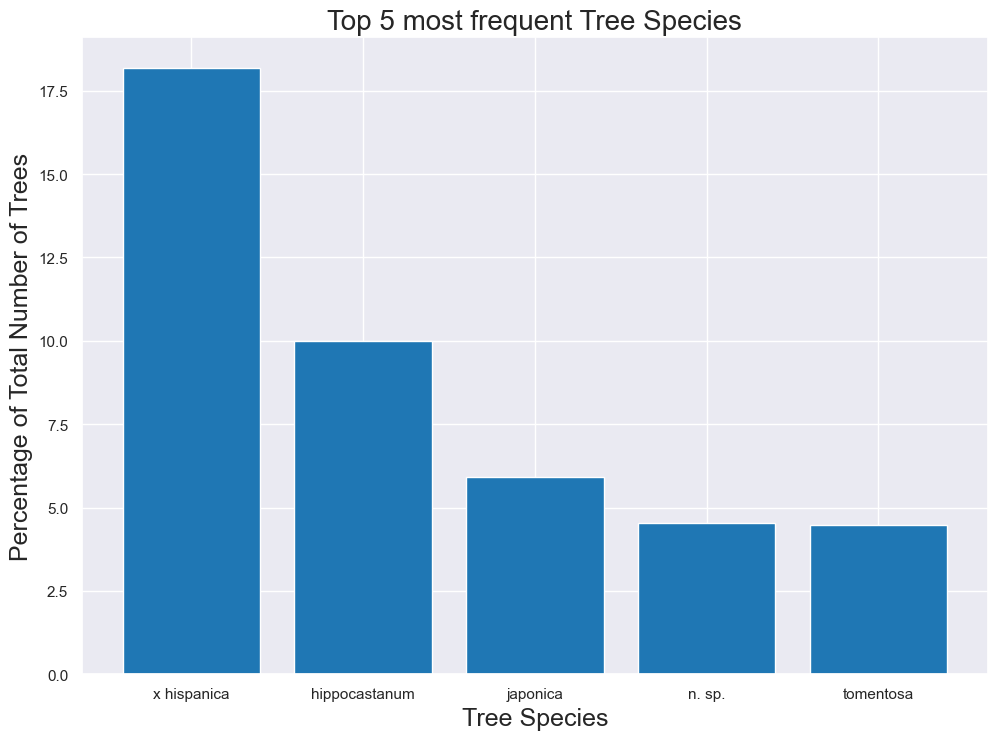

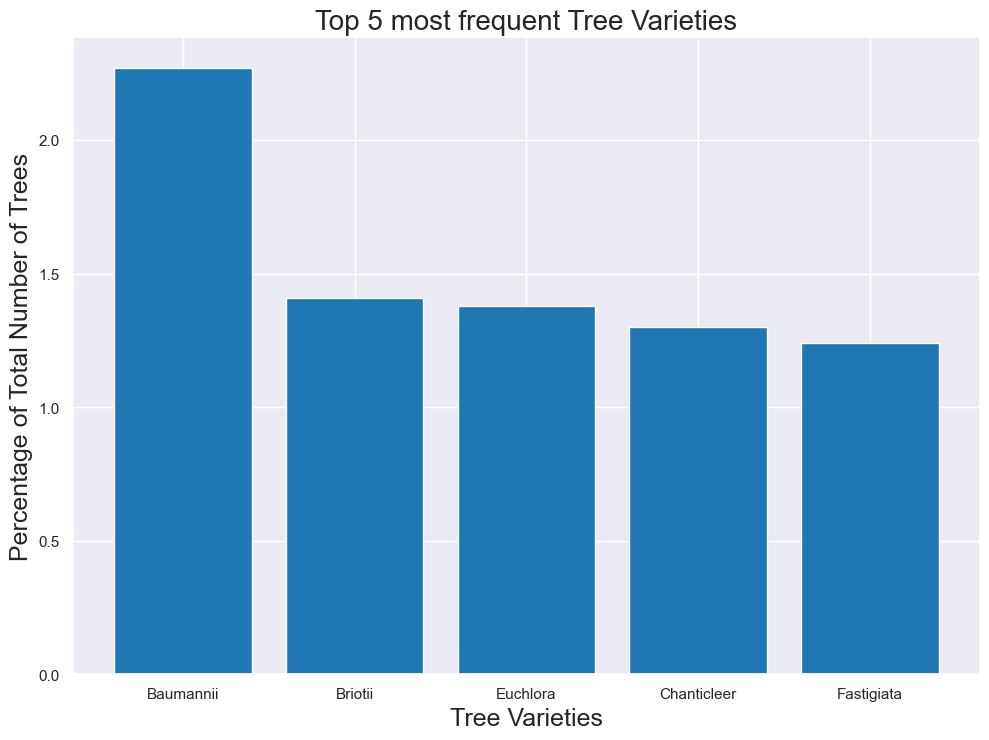

In [43]:
columns = [["arrondissement","Districts"],["tree_name","Tree Names"],["tree_type","Tree Types"],
           ["tree_specie","Tree Species"], ["variety", "Tree Varieties"]]

for c in columns:
    #Grouping by the variable chosen and counting the values, we use domain as our count variable since it is complete
    top_5 = tree[["domain",c[0]]].groupby(c[0]).count().reset_index().sort_values(by='domain', ascending=False)
    #Calculating percentage
    n = len(tree)
    top_5["pct"] = round(top_5["domain"]*100/n,2)
    top_5 = top_5.head(5)
    plt.bar(top_5[c[0]], top_5["pct"])
    plt.title("Top 5 most frequent "+c[1])
    plt.xlabel(c[1])
    plt.ylabel("Percentage of Total Number of Trees")
    plt.show()
    print()
    print()

In [44]:
top_5.sum().values[1]

15199

### 2.3 Bivariate analysis

#### 2.3.1 Correlation between 2 numerical variables

First we will run the .corr() function on our dataframe to create a heatmap of correlated (numerical) fields.

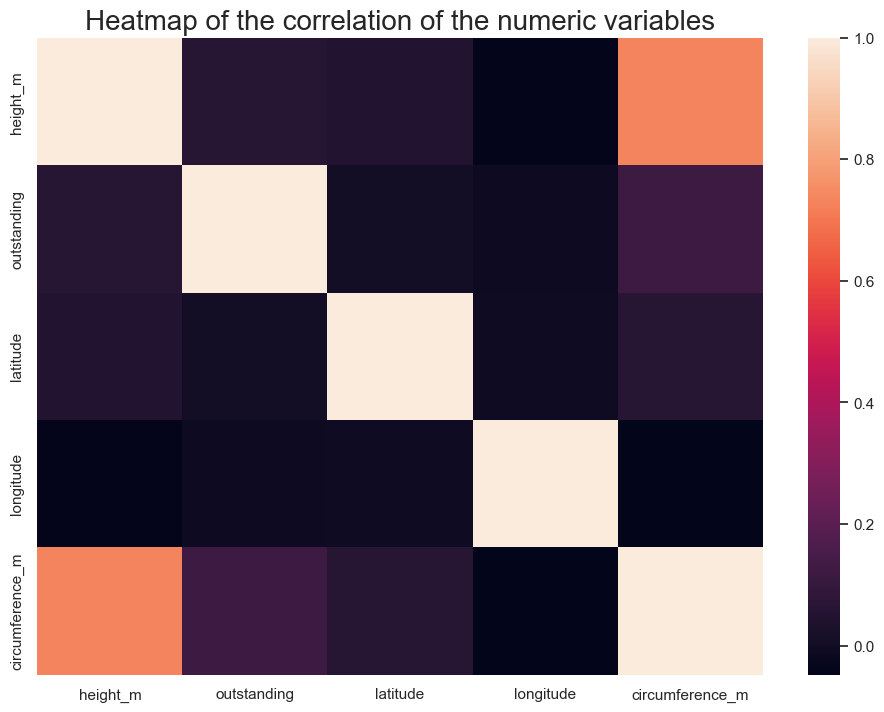

In [45]:
sns.heatmap(tree.drop(columns={'circumference_cm'}).corr())
plt.title("Heatmap of the correlation of the numeric variables")
plt.show()

In [46]:
#Clearly, the only variables that seem corelated are circumference and height_m
#Let's calculate the R²

#Importing statistical functions
import scipy.stats as st

#Creating a dataframe where neither values are equal to NaN
subset = tree.loc[(~tree.height_m.isna()) & (~tree.circumference_m.isna())]

r = round(st.pearsonr(subset["height_m"],subset["circumference_m"])[0],2)

print("r coefficient of circumference and height is :", r,"High correlation")

r coefficient of circumference and height is : 0.73 High correlation


In [47]:
tree.corr()

,circumference_cm,height_m,outstanding,latitude,longitude,circumference_m
circumference_cm,1.000000,0.732595,0.116398,0.061736,-0.047956,1.000000
height_m,0.732595,1.000000,0.061655,0.049572,-0.041676,0.732595
outstanding,0.116398,0.061655,1.000000,0.003465,-0.011759,0.116398
latitude,0.061736,0.049572,0.003465,1.000000,-0.010613,0.061736
longitude,-0.047956,-0.041676,-0.011759,-0.010613,1.000000,-0.047956
circumference_m,1.000000,0.732595,0.116398,0.061736,-0.047956,1.000000


#### 2.3.2 Correlation between 2 categorical variables
    

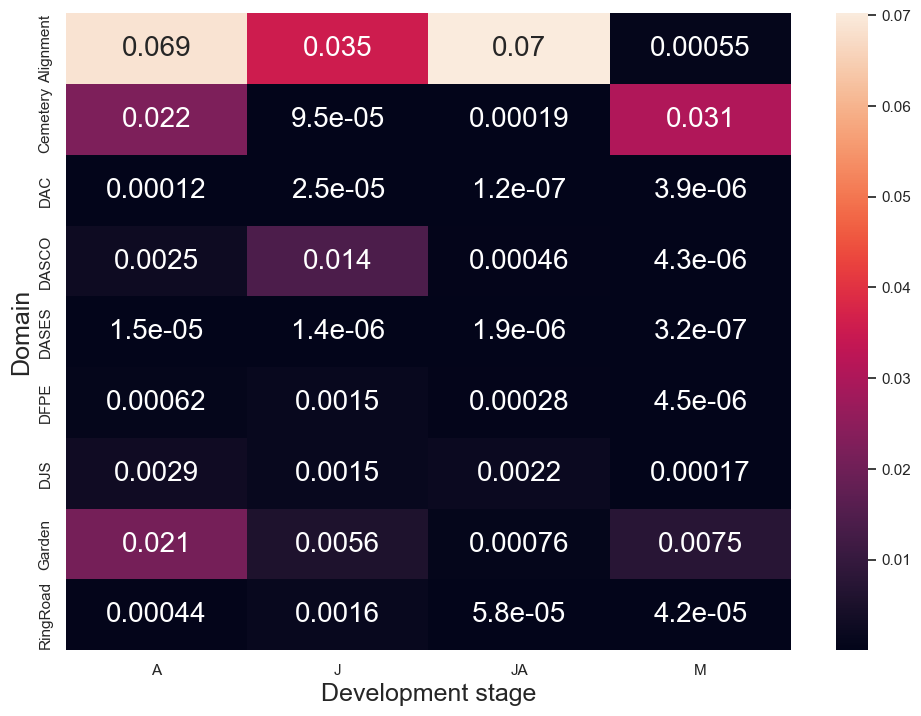

Moderate association between Development stage and Domain, Cramer's V = 0.3455368719836405


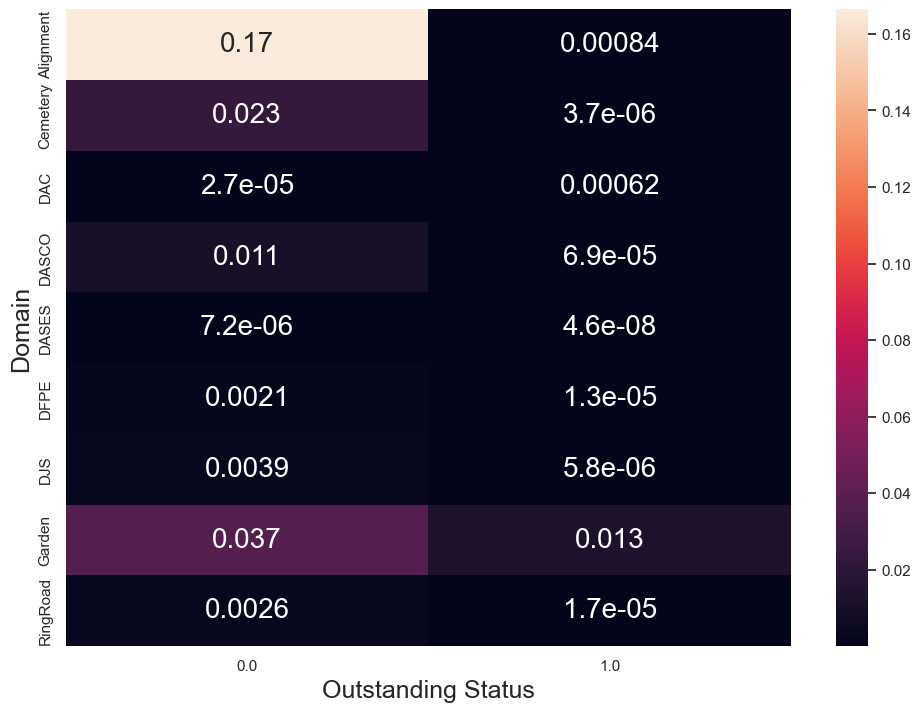

Moderate association between Outstanding Status and Domain, Cramer's V = 0.4490810455052172


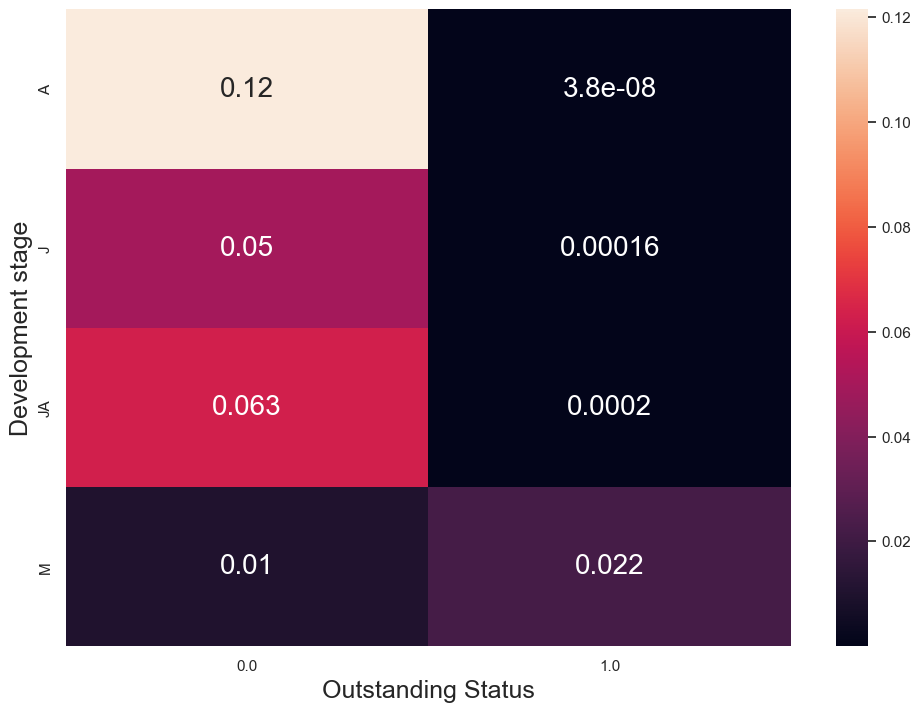

High association between Outstanding Status and Development stage, Cramer's V = 0.5665896979370022


In [48]:
#Defining a function to define association between 2 categorical variables
def association(r):
    if abs(r) > 1: return 'Association wrongly calculated, cannot be > 1'
    elif abs(r) > 0.5: return 'High association'  
    elif abs(r) > 0.3: return 'Moderate association' 
    elif abs(r) > 0.1: return 'Low association' 
    else: return 'Little if any association' 


columns = [["domain","Domain"],["development_stage","Development stage"],
           ["outstanding","Outstanding Status"]]


from scipy.stats import chi2_contingency

for c in combinations(columns,2):
    #Creating a subset of our dataset where both categories are not NA
    subset = tree.loc[(~tree[c[0][0]].isna()) & (~tree[c[1][0]].isna())]
    X = c[0][0]
    Y = c[1][0]
    xlabel = c[1][1]
    ylabel = c[0][1]
    pivot = subset[[X,Y]].pivot_table(index=X,columns=Y, aggfunc=len, margins=True,
                               margins_name="Total")

    tx = pivot.loc[:,["Total"]]
    ty = pivot.loc[["Total"],:]

    n = len(tree)
    #Here n will be the total number of observations
    indep = tx.dot(ty) / n

    clean = pivot.fillna(0) # Null values are replaced by 0
    #Creating heatmap
    measure = (clean-indep)**2/indep
    #Calculating xi²
    xi_n = measure.sum().sum()
    table = measure/xi_n
    sns.heatmap(table.iloc[:-1,:-1],annot=table.iloc[:-1,:-1])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    #Calculating Cramer's V
    minimum_dimension = min(table.shape)-1
    v = np.sqrt((xi_n/n) / minimum_dimension)
    print("{} between {} and {}, Cramer's V = {}".format(association(v), xlabel, ylabel, v))

#### 2.3.3 Correlation between a categorical and numeric variables

We will calculate eta_squared to calculate the relationship between categorical and numeric variables in our dataset.

No significant correlation between Circumference and Domain, ETA squared = 0.02
Strong correlation between Circumference and Development stage, ETA squared = 0.51
No significant correlation between Circumference and Outstanding Status, ETA squared = 0.01
No significant correlation between Height and Domain, ETA squared = 0.09
Moderate Correlation between Height and Development stage, ETA squared = 0.38
No significant correlation between Height and Outstanding Status, ETA squared = 0.0
No significant correlation between Latitude and Domain, ETA squared = 0.01
No significant correlation between Latitude and Development stage, ETA squared = 0.01
No significant correlation between Latitude and Outstanding Status, ETA squared = 0.0
No significant correlation between Longitude and Domain, ETA squared = 0.04
No significant correlation between Longitude and Development stage, ETA squared = 0.01
No significant correlation between Longitude and Outstanding Status, ETA squared = 0.0


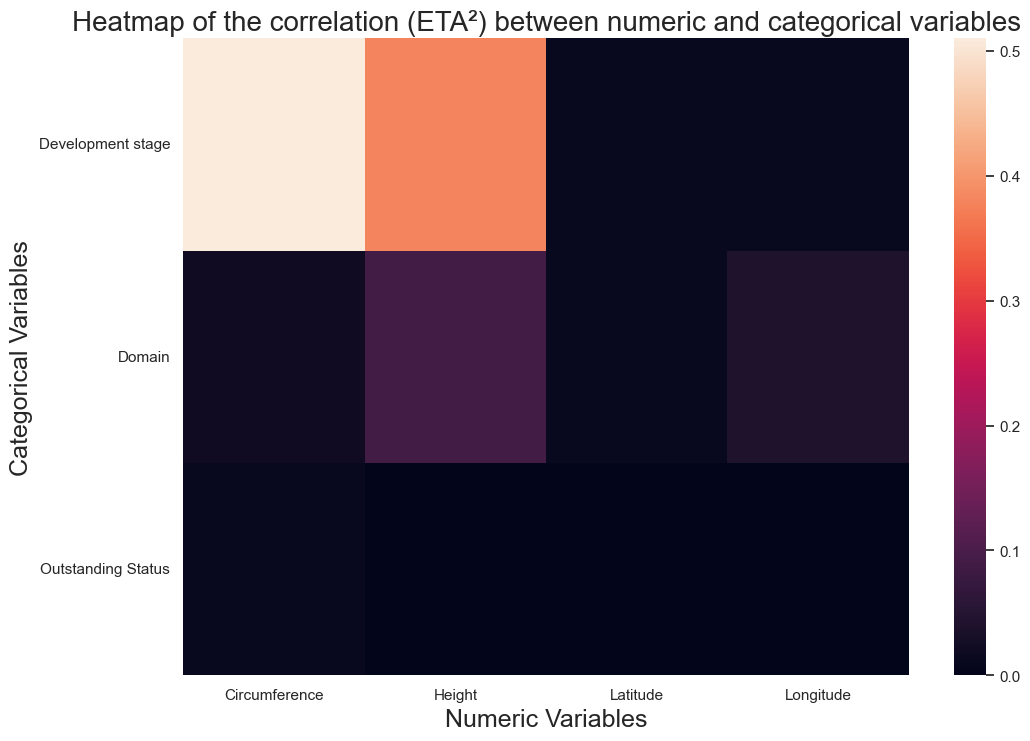

In [49]:
#Defining eta_squared
def eta_squared(x,y):
    mean_y = y.mean()
    categories = []
    for category in x.unique():
        yi_category = y[x==category]
        categories.append({'ni': len(yi_category),
                        'mean_category': yi_category.mean()})
    TSS = sum([(yj-mean_y)**2 for yj in y])
    ESS = sum([c['ni']*(c['mean_category']-mean_y)**2 for c in categories])
    return ESS/TSS

#Defining a function to define correlation
def correlation(r):
    if abs(r) > 1: return 'Correlation wrongly calculated, cannot be > 1'
    elif abs(r) > 0.7: return 'Strong correlation'  
    elif abs(r) > 0.5: return 'Moderate Correlation' 
    elif abs(r) > 0.3: return 'Weak correlation' 
    else: return 'No significant correlation' 

num = [["Circumference","circumference_m", "m"],["Height","height_m", "m"],
           ["Latitude","latitude", "degrees"], ["Longitude","longitude", "degrees"]]

categ = [["domain","Domain"],["development_stage","Development stage"],
           ["outstanding","Outstanding Status"]]

#df = pd.DataFrame(index=[c[1] for c in categ], columns=[n[0] for n in num], val='eta_2')

arr = []

for i in range(len(num)):
    for j in range(len(categ)):
        #Creating subset without null values
        subset = tree.loc[(~tree[num[i][1]].isna()) & (~tree[categ[j][0]].isna())]
        eta_2 = round(eta_squared(subset[categ[j][0]], subset[num[i][1]]),2)
        print("{} between {} and {}, ETA squared = {}".format(correlation(np.sqrt(eta_2)),num[i][0],categ[j][1],eta_2))
        #df.loc[categ[j][1],num[i][0]] = eta_2
        dict2 = {'num': num[i][0], 'cat': categ[j][1], 'eta_2': eta_2}
        arr.extend([dict2])

df = pd.DataFrame(arr)
heat_map = pd.pivot_table(data=df, columns='num', index='cat', values='eta_2')
g = sns.heatmap(heat_map)
plt.yticks(rotation=0)
plt.xlabel("Numeric Variables")
plt.ylabel("Categorical Variables")
plt.title("Heatmap of the correlation (ETA²) between numeric and categorical variables")
plt.show()



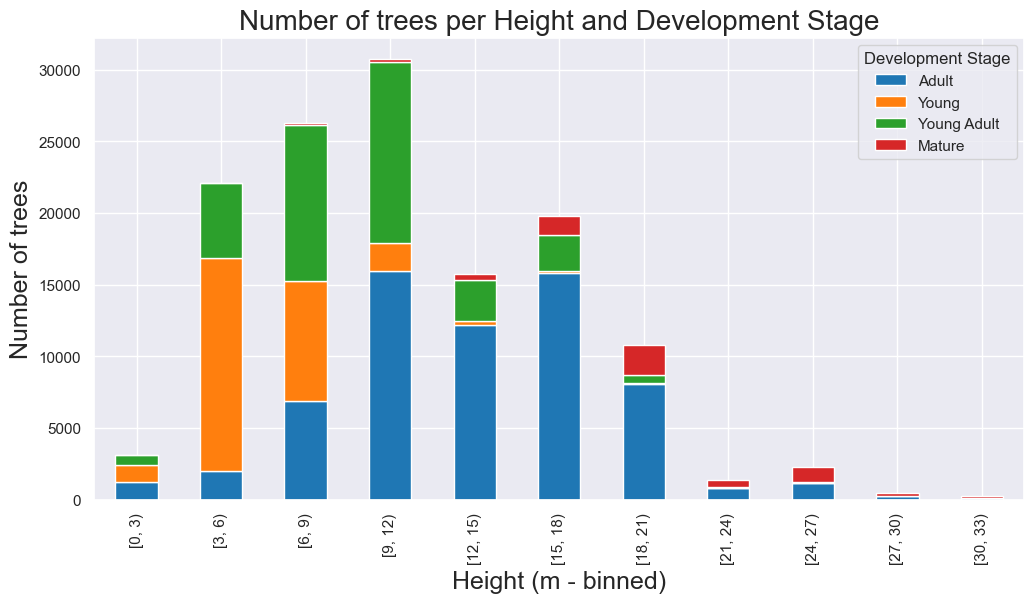

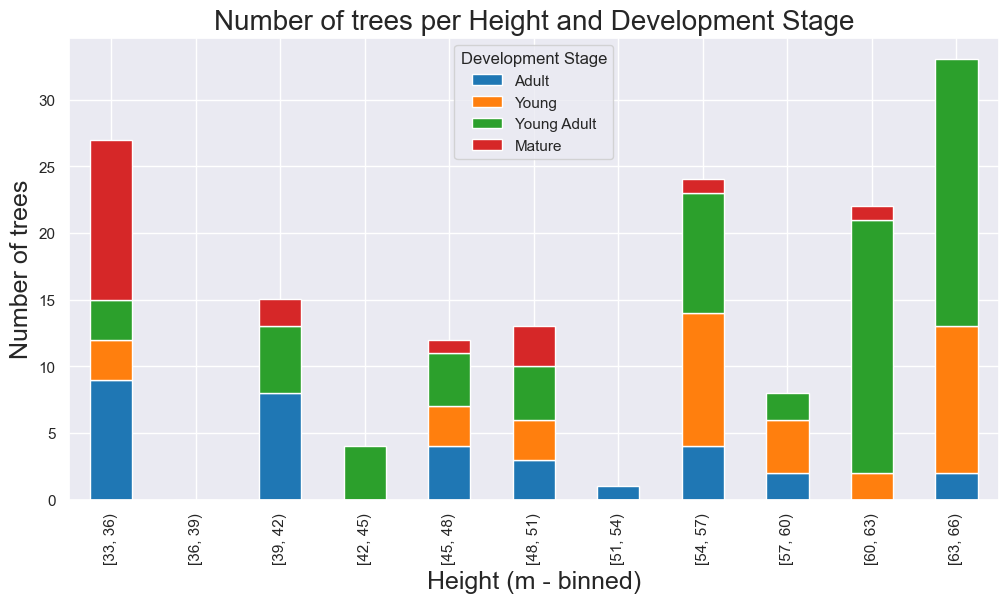

In [50]:
#Creating development stage subset for analysis of heights
ds_subset = tree.groupby(["development_stage","height_m"]).agg(count=('development_stage','count')).reset_index()

ds_subset

#Excluding values over 30m because they are almost not represented
bins = np.arange(0,36,3)

#We aggregate over 5 m height_bins
ds_subset['height_bin'] = pd.cut(ds_subset.height_m, bins,  right=False)

#Aggregating by bin and development stage
subset = ds_subset[["height_bin","development_stage","count"]].groupby(["height_bin","development_stage"]).sum()

#Pivoting over development stage for display of stacked bar chart
subset = subset.reset_index().pivot_table(columns='development_stage', index="height_bin", values="count")

#Displaying stacked bar chart
subset.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Number of trees per Height and Development Stage")
plt.xlabel("Height (m - binned)")
plt.ylabel("Number of trees")
plt.legend(title="Development Stage", labels=["Adult","Young","Young Adult","Mature"])
plt.show()

#Studying only values over 30m (outliers)
bins = np.arange(33,69,3)

#We aggregate over 5 m height_bins
ds_subset['height_bin'] = pd.cut(ds_subset.height_m, bins,  right=False)

#Aggregating by bin and development stage
subset = ds_subset[["height_bin","development_stage","count"]].groupby(["height_bin","development_stage"]).sum()

#Pivoting over development stage for display of stacked bar chart
subset = subset.reset_index().pivot_table(columns='development_stage', index="height_bin", values="count")

#Displaying stacked bar chart
subset.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Number of trees per Height and Development Stage")
plt.xlabel("Height (m - binned)")
plt.ylabel("Number of trees")
plt.legend(title="Development Stage", labels=["Adult","Young","Young Adult","Mature"])
plt.show()

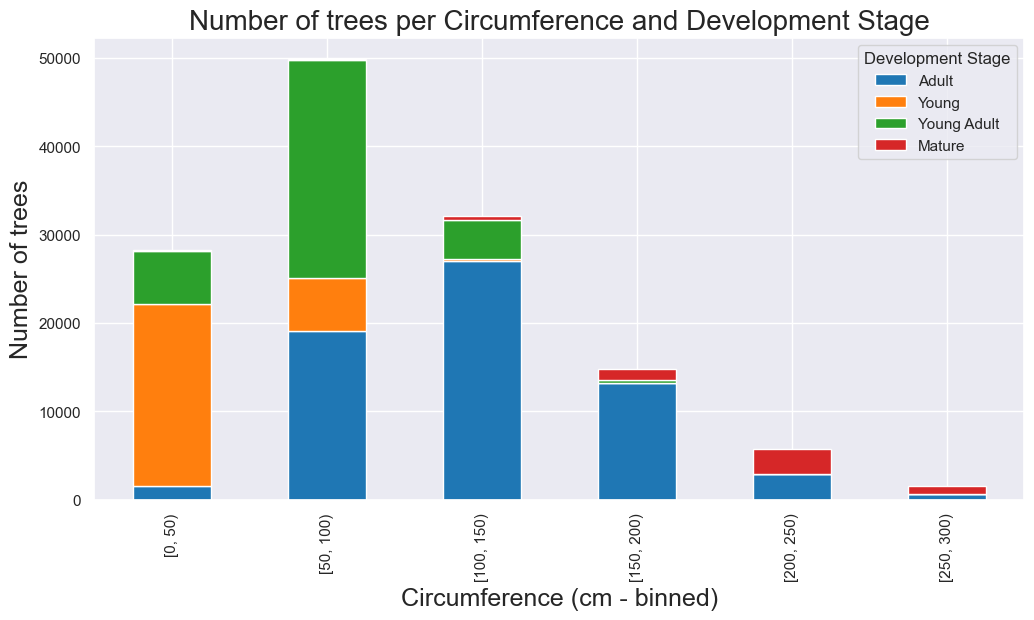

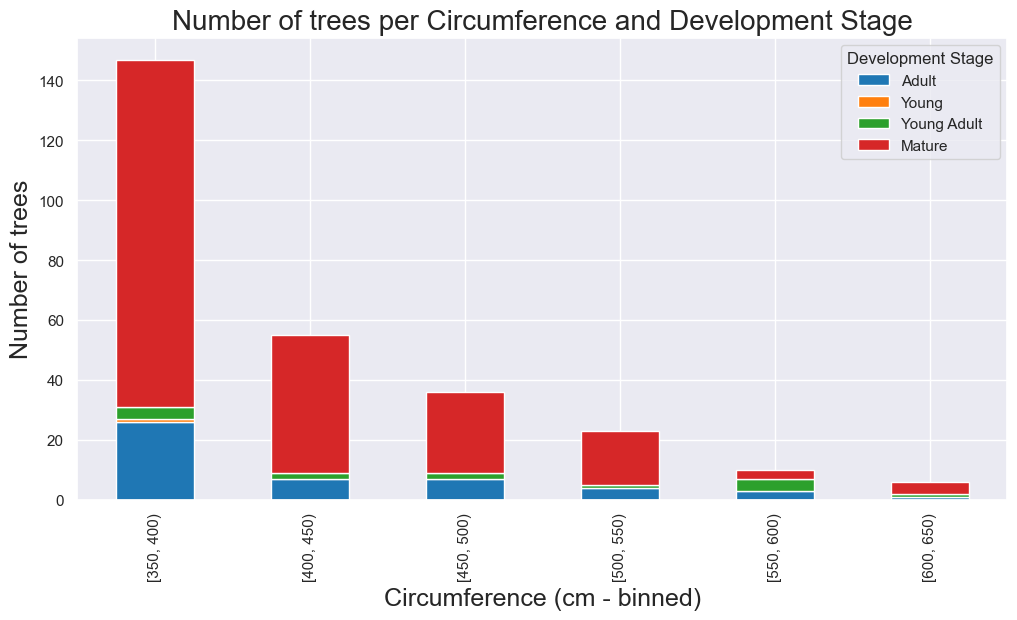

In [51]:
#Creating development stage subset for analysis of circumference
ds_subset = tree.groupby(["development_stage","circumference_cm"]).agg(count=('development_stage','count')).reset_index()

ds_subset

#Excluding values over 3m because they are almost not represented
bins = np.arange(0,350,50)

#We aggregate over 50cm circumference bins
ds_subset['circum_bin'] = pd.cut(ds_subset.circumference_cm, bins,  right=False)

#Aggregating by bin and development stage
subset = ds_subset[["circum_bin","development_stage","count"]].groupby(["circum_bin","development_stage"]).sum()

#Pivoting over development stage for display of stacked bar chart
subset = subset.reset_index().pivot_table(columns='development_stage', index="circum_bin", values="count")

#Displaying stacked bar chart
subset.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Number of trees per Circumference and Development Stage")
plt.xlabel("Circumference (cm - binned)")
plt.ylabel("Number of trees")
plt.legend(title="Development Stage", labels=["Adult","Young","Young Adult","Mature"])
plt.show()

#Studying only values over 30m (outliers)
bins = np.arange(350,700,50)

#We aggregate over 50cm circumference bins
ds_subset['circum_bin'] = pd.cut(ds_subset.circumference_cm, bins,  right=False)

#Aggregating by bin and development stage
subset = ds_subset[["circum_bin","development_stage","count"]].groupby(["circum_bin","development_stage"]).sum()

#Pivoting over development stage for display of stacked bar chart
subset = subset.reset_index().pivot_table(columns='development_stage', index="circum_bin", values="count")

#Displaying stacked bar chart
subset.plot(kind="bar", stacked=True, figsize=(12,6))
plt.title("Number of trees per Circumference and Development Stage")
plt.xlabel("Circumference (cm - binned)")
plt.ylabel("Number of trees")
plt.legend(title="Development Stage", labels=["Adult","Young","Young Adult","Mature"])
plt.show()

### 2.4 Creating clusters from coordinates

We will now create clusters with coordinates data to optimize the work of tree maintenance crews. An ideal data that we don't have is how many trees they can handle every day, we could use that data to create clusters with the good number of trees and that could help the maintenance crew pilot its activities.

#### 2.4.1 Finding the right amount of clusters using the Elbow Method

In [52]:
#Creating a subset of data with only the coordinate data
location_df = tree[["latitude","longitude"]].copy()

#Importing scaling and Kmeans packages
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

#Scaling our data
mms = MinMaxScaler()
mms.fit(location_df)
location_scaled = mms.transform(location_df)

In [53]:
from sklearn.metrics import calinski_harabasz_score

SSD = []
CH = []

#Iterating over the possible number of Ks, we will use 20 at first
for k in range(2,21):
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(location_scaled)
    SSD.append(km.inertia_)
    CH.append(calinski_harabasz_score(location_scaled, labels))

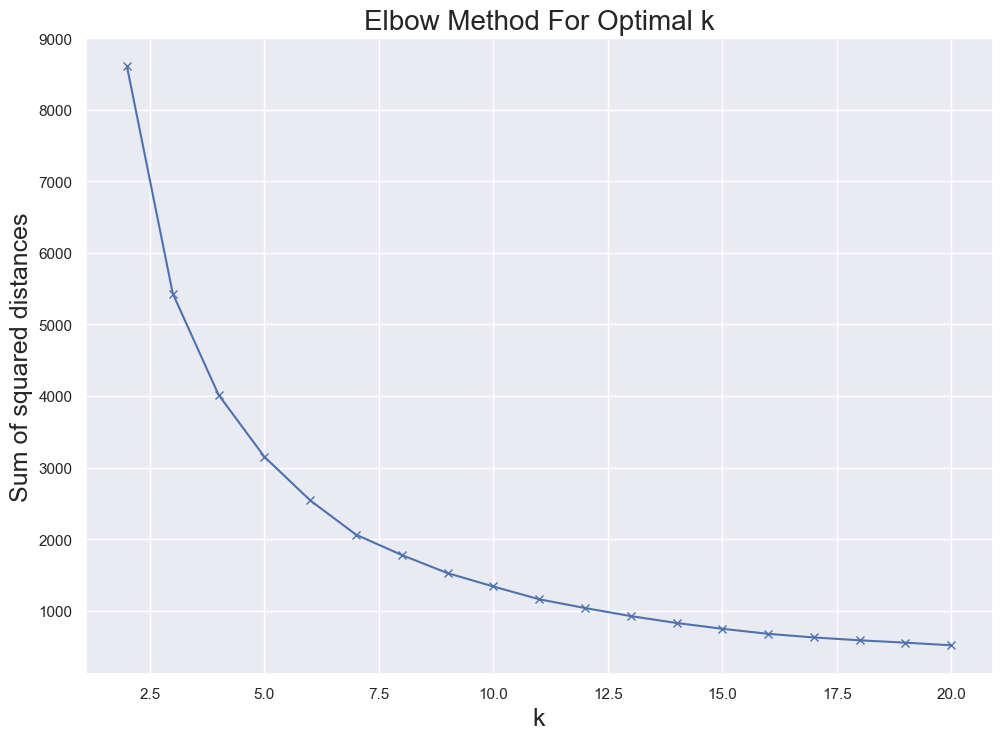

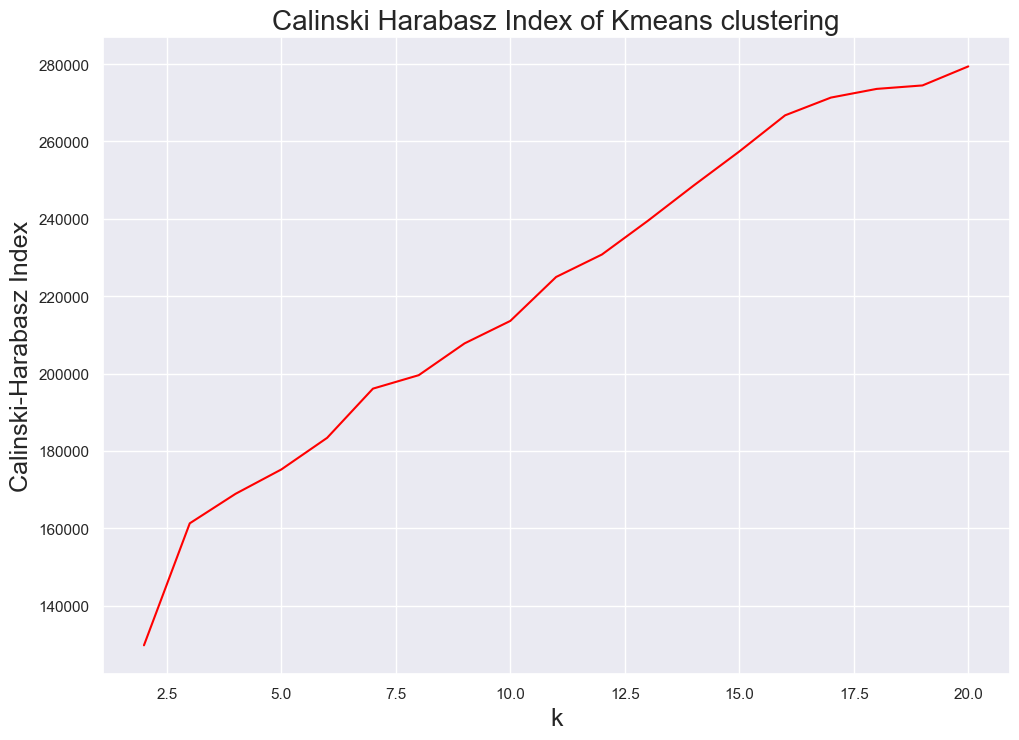

In [54]:
#Plotting our Elbow Score
plt.plot(range(2,21), SSD, 'bx-', label = "SSD")
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

#Displaying the CH index
plt.plot(range(2,21), CH, color="red", label="CH score")
plt.xlabel('k')
plt.ylabel("Calinski-Harabasz Index")
plt.title("Calinski Harabasz Index of Kmeans clustering")
plt.show()

Analysis of the Elbow curve seems to show that **7 is the best number of clusters**, which is somewhat confirmed by the CH index curve with a small peak at k=7.

#### 2.4.2 Applying Kmeans clustering to our coordinates dataset

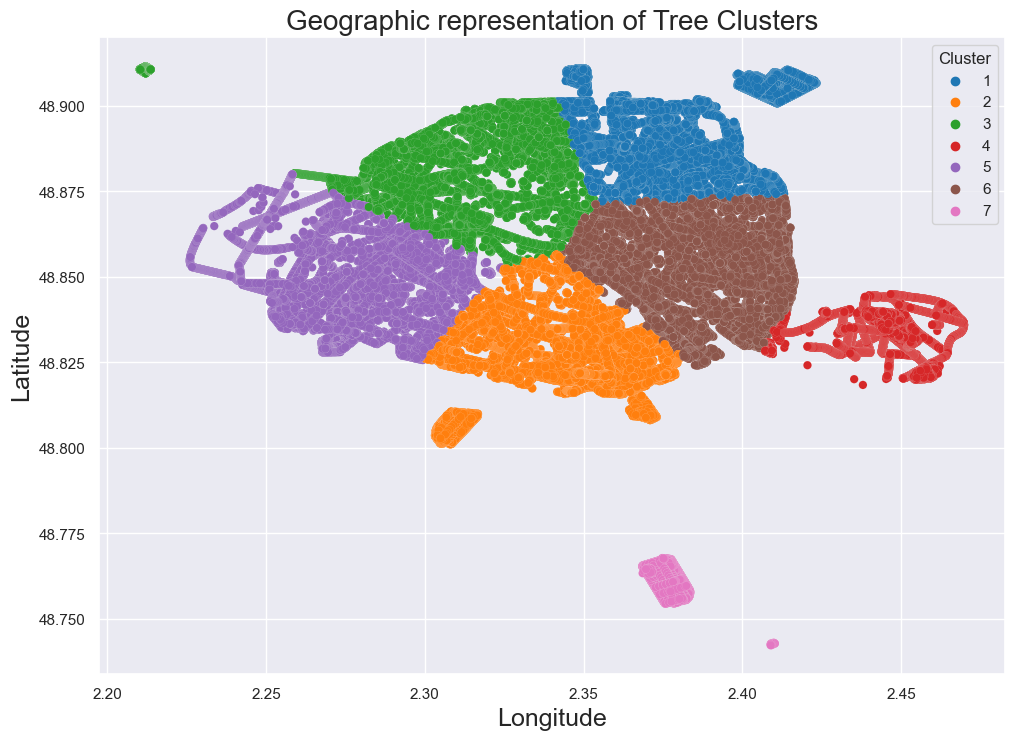

In [55]:
#Defining our Kmeans clustering algorithm with 7 clusters
km = KMeans(n_clusters=7)
#Calculating the clusters
clusters = km.fit_predict(location_scaled)

#Adding the clusters to our initial database
location_df["cluster"] = clusters

#Changing the base index of our clusters from 0 to 1
location_df["cluster"] = location_df["cluster"] + 1

#Creating a scatterplot of our clusters plotted on a map
sns.scatterplot(data=location_df, x='longitude', y='latitude', hue='cluster', palette='tab10', linewidth=0.05)
plt.title("Geographic representation of Tree Clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.show()

We can see that our Kmeans clustering has allowed us to **cleanly separate the tree clusters**. The next step would be to calculate the shortest path to go to each tree of each cluster but that is well beyond the scope of this project.

## 3. Conclusion

Our data analysis has allowed us to outline several key characteristics of trees referenced in this database.

Our findings will be summarized in the Powerpoint presentation present in the same folder as this notebook.  